In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:23<00:00, 104MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
!pip install torch torchvision numpy pandas matplotlib scikit-image lime grad-cam opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=042e29671afd0c3f0a8b66a47046b456d7b5d714809cb9ff6b376e103b31d55e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=55a3d9c73e28a7931117b3741ac5aff796bcda8f03ab63469fe009c6b0ba3912
  Stored in directory: /root/.cache/pip/wheels/8b/0d/d2/b12bec1ccc028921fb98158042ade2d19dae73925dfc636954
Successfully built lime grad-cam


In [ ]:
!cp -r /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2 /content/chest-xray-pneumonia

In [ ]:
!pip install torch torchvision --upgrade
!pip install tqdm scikit-learn seaborn

In [ ]:
import os, copy, torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

torch.backends.cudnn.benchmark = True

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=15, scale=(0.7, 1.3)),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
data_dir = '/content/chest-xray-pneumonia/chest_xray'

image_datasets = {
    x: ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val', 'test']
}

batch_size = 32 
num_workers = 4 

dataloaders = {
    x: DataLoader(
        image_datasets[x],
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    for x in ['train', 'val', 'test']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [ ]:
model = torchvision.models.efficientnet_v2_l(weights='IMAGENET1K_V1')

for param in model.features[:-4].parameters():
    param.requires_grad = False
for param in model.features[-4:].parameters():
    param.requires_grad = True

num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(num_ftrs, 2)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
num_normal = len(image_datasets['train'].samples) - sum(image_datasets['train'].targets)
num_pneumonia = sum(image_datasets['train'].targets)
total_samples = num_normal + num_pneumonia

class_weights = torch.tensor([
    total_samples / num_normal,
    total_samples / num_pneumonia
], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
optimizer = optim.Adam([
    {'params': model.features[:-4].parameters(), 'lr': 1e-5},
    {'params': model.features[-4:].parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
], weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
from torch.amp import autocast, GradScaler

scaler = GradScaler(enabled=(device.type == 'cuda'))

In [ ]:
num_epochs = 25
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase}ing", unit="batch"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with autocast(device_type='cuda', enabled=(device.type == 'cuda' and phase == 'train')):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            if phase == 'train':
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += preds.eq(labels.view_as(preds)).sum().item()

        if phase == 'train':
            scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val':
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print('Early stopping triggered')
                    early_stop = True
                    break

    if early_stop:
        break

print(f'Best val Acc: {best_acc:.4f}')

model.load_state_dict(best_model_wts)

model_save_path = 'pneumonia_detection_model_efficientnetv21.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/25
----------


training: 100%|██████████| 163/163 [06:24<00:00,  2.36s/batch]


train Loss: 0.2101 Acc: 0.9109


valing: 100%|██████████| 1/1 [00:02<00:00,  2.63s/batch]


val Loss: 0.3472 Acc: 0.8750
Epoch 2/25
----------


training: 100%|██████████| 163/163 [06:15<00:00,  2.31s/batch]


train Loss: 0.1224 Acc: 0.9546


valing: 100%|██████████| 1/1 [00:00<00:00,  1.02batch/s]


val Loss: 0.1149 Acc: 1.0000
Epoch 3/25
----------


training: 100%|██████████| 163/163 [06:14<00:00,  2.30s/batch]


train Loss: 0.1132 Acc: 0.9565


valing: 100%|██████████| 1/1 [00:00<00:00,  1.33batch/s]


val Loss: 0.2720 Acc: 0.8750
Epoch 4/25
----------


training: 100%|██████████| 163/163 [06:16<00:00,  2.31s/batch]


train Loss: 0.0907 Acc: 0.9622


valing: 100%|██████████| 1/1 [00:00<00:00,  1.32batch/s]


val Loss: 0.1379 Acc: 1.0000
Epoch 5/25
----------


training: 100%|██████████| 163/163 [06:15<00:00,  2.30s/batch]


train Loss: 0.0834 Acc: 0.9689


valing: 100%|██████████| 1/1 [00:00<00:00,  1.32batch/s]


val Loss: 0.2942 Acc: 0.9375
Epoch 6/25
----------


training: 100%|██████████| 163/163 [06:15<00:00,  2.30s/batch]


train Loss: 0.0838 Acc: 0.9689


valing: 100%|██████████| 1/1 [00:00<00:00,  1.32batch/s]


val Loss: 0.1903 Acc: 0.9375
Epoch 7/25
----------


training: 100%|██████████| 163/163 [06:18<00:00,  2.32s/batch]


train Loss: 0.0773 Acc: 0.9707


valing: 100%|██████████| 1/1 [00:00<00:00,  1.36batch/s]


val Loss: 0.0550 Acc: 1.0000
Epoch 8/25
----------


training: 100%|██████████| 163/163 [06:20<00:00,  2.33s/batch]


train Loss: 0.0578 Acc: 0.9804


valing: 100%|██████████| 1/1 [00:01<00:00,  1.10s/batch]


val Loss: 0.0672 Acc: 1.0000
Epoch 9/25
----------


training: 100%|██████████| 163/163 [06:15<00:00,  2.30s/batch]


train Loss: 0.0461 Acc: 0.9820


valing: 100%|██████████| 1/1 [00:01<00:00,  1.09s/batch]


val Loss: 0.0744 Acc: 1.0000
Epoch 10/25
----------


training: 100%|██████████| 163/163 [06:15<00:00,  2.31s/batch]


train Loss: 0.0454 Acc: 0.9849


valing: 100%|██████████| 1/1 [00:00<00:00,  1.20batch/s]


val Loss: 0.1001 Acc: 0.9375
Epoch 11/25
----------


training: 100%|██████████| 163/163 [06:14<00:00,  2.29s/batch]


train Loss: 0.0440 Acc: 0.9826


valing: 100%|██████████| 1/1 [00:00<00:00,  1.36batch/s]


val Loss: 0.1200 Acc: 0.9375
Epoch 12/25
----------


training: 100%|██████████| 163/163 [06:16<00:00,  2.31s/batch]


train Loss: 0.0388 Acc: 0.9856


valing: 100%|██████████| 1/1 [00:00<00:00,  1.31batch/s]


val Loss: 0.1597 Acc: 0.9375
Early stopping triggered
Best val Acc: 0.0000
Model saved to pneumonia_detection_model_efficientnetv21.pth


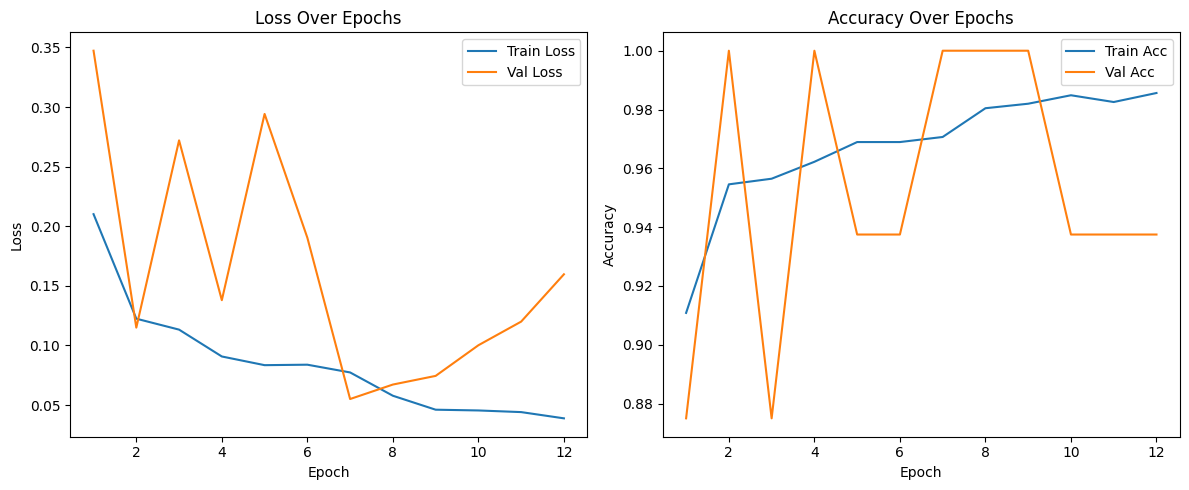

Test Accuracy:   0.9455
Test Precision:  0.9428
Test Recall:     0.9718
Test F1 Score:   0.9571
Test AUC:        0.9368


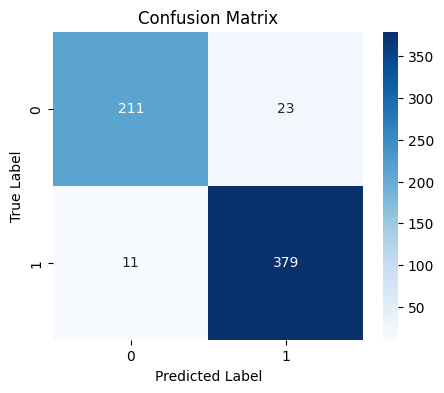

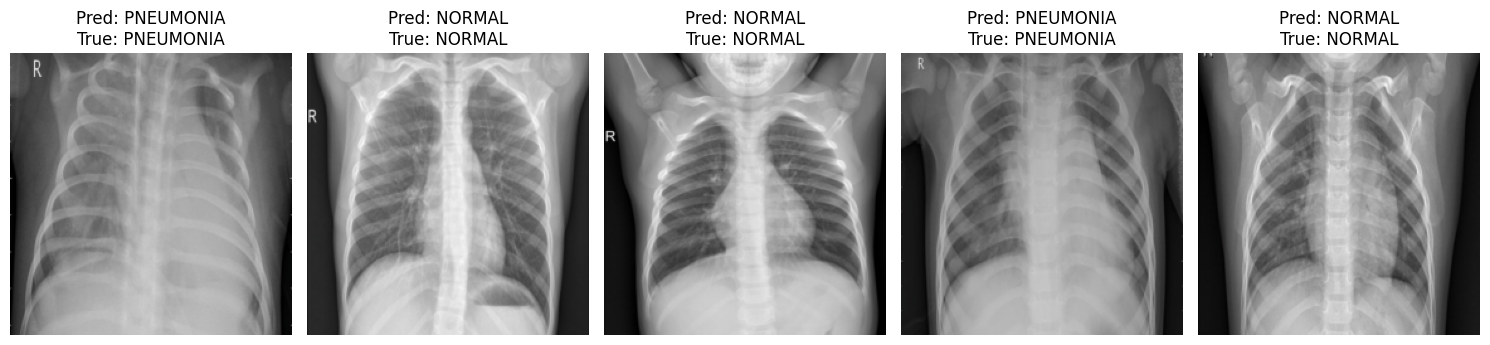

In [ ]:
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
train_accs_ = [float(a) for a in train_accs]
val_accs_   = [float(a) for a in val_accs]

plt.plot(range(1, len(train_accs_)+1), train_accs_, label='Train Acc')
plt.plot(range(1, len(val_accs_)+1), val_accs_, label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

test_acc    = accuracy_score(all_labels, all_preds)
test_prec   = precision_score(all_labels, all_preds, average='binary')
test_recall = recall_score(all_labels, all_preds, average='binary')
test_f1     = f1_score(all_labels, all_preds, average='binary')

try:
    test_auc = roc_auc_score(all_labels, all_preds)
except ValueError:
    test_auc = None

print(f"Test Accuracy:   {test_acc:.4f}")
print(f"Test Precision:  {test_prec:.4f}")
print(f"Test Recall:     {test_recall:.4f}")
print(f"Test F1 Score:   {test_f1:.4f}")
if test_auc is not None:
    print(f"Test AUC:        {test_auc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

class_names = image_datasets['train'].classes
test_dataset = image_datasets['test']

random_indices = random.sample(range(len(test_dataset)), 5)

plt.figure(figsize=(15,6))

for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]
    input_tensor = image.unsqueeze(0).to(device) 

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    image_np = image.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    image_np = std * image_np + mean
    image_np = np.clip(image_np, 0, 1)

    plt.subplot(1, 5, i+1)
    plt.imshow(image_np)
    plt.title(f"Pred: {class_names[pred.item()]}\nTrue: {class_names[label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()
